# Import necessary packages

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from eval import get_run_metrics, read_run_dir, get_model_from_run
from samplers import get_data_sampler, sample_transformation
from tasks import get_task_sampler
from bertviz import head_view

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'whitegrid')
palette = sns.color_palette('colorblind')

run_dir = "/Users/harmonbhasin/hsbhasin@wisc.edu - Google Drive/My Drive/ICL/Models"
df = read_run_dir(run_dir)

# Define function for multiple model plotting

In [2]:
def run_att_evaluation(subset_models, task_args, data_args, seed):
    models = {}
    configs = {}
    n_points = 100
    n_dims = 20
    b_size = 1

    for key in subset_models:
        task = df.task[subset_models[key]]
        run_id = df.run_id[subset_models[key]]
        run_path = os.path.join(run_dir, task, run_id)
        models[key], configs[key] = get_model_from_run(run_path)

    vizDict = {}

    for task_key in task_args:
        current_task = task_args[task_key]
        task_sampler = get_task_sampler(
            current_task['task'],
            n_dims,
            b_size,
            **{i: current_task[i] for i in current_task if i != 'task'}
        )
        print('Conducting evaluation on', current_task['task'], 'with degree of ', current_task['degree'], '\n')
        for data_key in data_args:
            torch.manual_seed(seed)
            current_data = data_args[data_key]
            sample_args = {}

            if current_data['type'] == 'Skewed':
                eigenvals = 1 / (torch.arange(n_dims) + 1)
                scale = sample_transformation(eigenvals, normalize=True)
                sample_args['scale'] = scale

            for data_info in current_data:
                if data_info != 'data' and data_info != 'type':
                    sample_args[data_info] = current_data[data_info]

            data_sampler = get_data_sampler(current_data['data'], n_dims, **sample_args)

            # Create an instance of the function class sampler; add seed stuff here
            task = task_sampler()

            # Generate x points; add seed stuff here
            xs = data_sampler.sample_xs(n_points, b_size)

            # Generate y points
            ys = task.evaluate(xs)

            for model_key in models:
                prompt_col = 0
                prompt_row = 0
                conf = configs[model_key]['training']
                prompt_args = conf['prompt_kwargs']
                if len(prompt_args) != 0:
                       if prompt_args['type'] == 'data':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(data_key[-1])
                           prompt_col = prompt_args['position']
                       elif prompt_args['type'] == 'task':
                           if prompt_args['encoding'] == 'dynamic':
                               prompt_row = int(task_key[-1])
                           prompt_col = prompt_args['position']

                temp_key = f"{model_key}_{task_key}_{data_key}"
                with torch.no_grad():
                    _, vizDict[temp_key], _ = models[model_key](xs,
                                                          ys,
                                                          conf['prompt_type'],
                                                          prompt_row,
                                                          prompt_col)
                    if conf['prompt_type'] == 'standard':
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution')
                    else:
                        print(configs[model_key]['wandb']['name'], 'evaluated on', data_args[data_key]['type'], data_args[data_key]['data'], 'distribution with instruction in row', prompt_row, 'and column', prompt_col)

    vizEntries = {}

    for key in vizDict:
        components = key.split('_')
        model = components[0]

        # Setup texts as replacement for the vectors so that we can use bertviz
        heatmap_begin = [i for i in range(0, n_points*2)]
        x_values = [f"$x_{{{i:02d}}}$" for i in range(1, n_points + 1)]
        y_values = [f"$y_{{{i:02d}}}$" for i in range(1, n_points + 1)]

        tokens = [value for pair in zip(x_values,y_values) for value in pair]

        if configs[model]['training']['prompt_type'] != "standard":
            heatmap_begin = [i for i in range(0, n_points*2+2)]
            tokens.insert(0,"$in_{{x}}$")
            tokens.insert(1,"$in_{{y}}$")

        vizEntries[model] = dict(zip(heatmap_begin,tokens))

    different_plots = {}

    for key in vizDict:
        components = key.split('_')
        model = components[0]
        task = components[1]
        data = components[2]
        task_data = f"{task}_{data}"
        if model not in different_plots:
            different_plots[model] = {}
        different_plots[model][task_data] = vizDict[key]

    return different_plots, vizDict, configs

In [81]:
def plot_heatmap_results(different_plots, vizDict, configs, task_args, data_args, head_dir, width=12,height=4):
    n_dims = 20

    rand_key = list(different_plots.keys())[0]

    num_cols = len(different_plots[rand_key])

    rand_key = list(vizDict.keys())[0]

    matrix_size = len(vizDict[rand_key])

    for key in different_plots:
        fig, axes = plt.subplots(1, num_cols, figsize=(width, height))
        model_spec = different_plots[key]
        index = 0
        for sub_key in model_spec:
            components = sub_key.split('_')
            task = components[0]
            data = components[1]

            attention = model_spec[sub_key]
            batch_size, num_heads, seq_len, _ = attention[0].shape
            output_matrix = np.zeros(shape=(12,8))
            for i in range(0, len(attention)):
                for j in range(0, num_heads):
                    att_matrix = attention[i][0][j,:,:]
                    masker = np.zeros(shape=matrix_size)
                    for h in range(0,matrix_size-1):
                        if (h+1) % 2 == 1:
                            masker[h] = att_matrix[h+1][h]
                    output_matrix[i][j] = masker.mean()

            df = pd.DataFrame(output_matrix)
            df.index +=1
            df.columns = [1, 2, 3, 4, 5, 6, 7, 8]

            sns.heatmap(df, cmap='viridis',cbar=False, ax=axes[index], vmin=0, vmax=0.5)#, annot=True, fmt='.1f')
            #heatmap = sns.heatmap(df, cmap='viridis',cbar=True, ax=axes[index], vmin=0, vmax=0.5)#, annot=True, fmt='.1f')
            #cbar = heatmap.collections[0].colorbar
            #cbar.ax.yaxis.label.set_fontname('Times New Roman')  # Set font to Times New Roman
            #cbar.ax.yaxis.label.set_fontsize(12)  # Set font size as needed

            #axes[index].set_title(f"Task: {task_args[task]['task']} with degree = {task_args[task]['degree']} \n Distribution: {data_args[data]['type']} {data_args[data]['data']} ", fontsize=10)
            #axes[index].set_ylabel('Layers', fontsize=9)
            #axes[index].set_xlabel('Heads', fontsize=9)
            axes[index].set_xticklabels(axes[index].get_xticklabels(), rotation=0, fontsize=12)
            axes[index].set_yticklabels(axes[index].get_yticklabels(), rotation=0, fontsize=12)
            for label in (axes[index].get_xticklabels() + axes[index].get_yticklabels()):
                label.set_fontname('Times New Roman')
                label.set_fontsize(12)
            axes[index].set_xlabel("Head", fontname='Times New Roman', fontsize=12)
            index += 1
        #plt.suptitle(f"{configs[key]['wandb']['name']}", fontsize=12)
        axes[0].set_ylabel("Layer", fontname='Times New Roman', fontsize=12)
        plt.tight_layout()
        #plt.show()
        plt.savefig(f"{head_dir}/att_{configs[key]['wandb']['name']}.pdf")

In [66]:
index = 0
model_selection = {}
model_to_name = {}

for task_name in df.task:
    #if "model_12" in task_name and '_i' not in task_name and 'quad' not in task_name or "model_11_gaussian" in task_name:
    if "model_12_binomial" in task_name and '_i' not in task_name:
        task_index = df.loc[df["task"] == task_name].index[0]
        model_selection[f'model{index}'] = task_index
        print(f"model{index}:", task_name)
        model_to_name[f"model{index}"] = task_name
        index+=1


model0: model_12_binomial


In [67]:
task_args = {'task0': {'task': "hermite_regression", 'degree': 1},
             'task1': {'task': "hermite_regression", 'degree': 2},
             'task2': {'task': "hermite_regression", 'degree': 3}}

data_args = {'data0': {'data': 'gaussian', 'type': 'Standard'}}
seed=-152

## Evaluate chosen models

In [68]:
different_plots, vizDict, configs = run_att_evaluation(subset_models=model_selection,
                   task_args=task_args,
                   data_args=data_args,
                   seed=seed)

Conducting evaluation on hermite_regression with degree of  1 

Hermite Binomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  2 

Hermite Binomial evaluated on Standard gaussian distribution
Conducting evaluation on hermite_regression with degree of  3 

Hermite Binomial evaluated on Standard gaussian distribution


## Selecting specific models to plot


In [69]:
head_dir="/Users/harmonbhasin/College/Research/huLab/paper_figures/new_task"

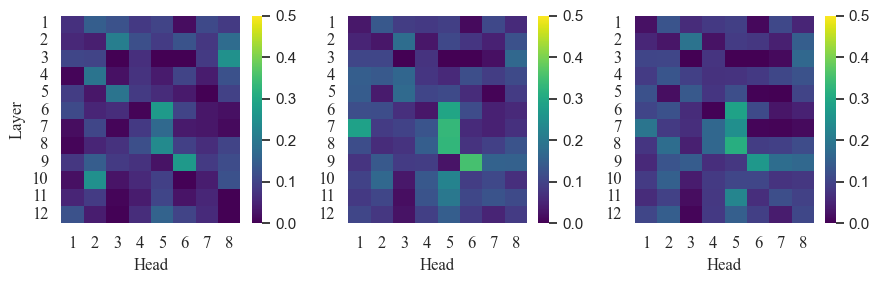

In [72]:
plot_heatmap_results(different_plots=different_plots,
                     vizDict=vizDict,
                     configs=configs,
                     task_args=task_args,
                     data_args=data_args,
                     width=9,
                     height=3,
                     head_dir=head_dir,
                     )
